# Variational Autoencoders
The variational autoencoder, or VAE is a directed model that uses learned approximate inference and can be trained purely with gradient-based methods.To generate a sample from the model, the VAE ﬁrst draws a sample $z$ from the code distribution $p_{model}(z)$. The sample is then run through a diﬀerentiable generator network $g(z)$. Finally, $x$ is sampled from a distribution $p_{model}(x;g(z)) =p_{model}(x | z)$. During training, however, the approximate inference network (or encoder) $q(z | x)$ is used to obtainz, and $p_{model}(x | z)$ is then viewed as a decoder network.
The key insight behind variational autoencoders is that they can be trained bymaximizing the variational lower bound $L(q)$ associated with data point $x$:

**(1)** $$\mathscr{L}(q) = \mathbb{E}_z \sim q(z|x)log p_{model}(z, x) + H(q(z | x)) $$


**(2)** $$\mathscr{L}(q)= \mathbb{E}_z \sim q(z|x)log p_{model}(x | z) - D_{KL}(q(z | x)\parallel p_{model}(z)) \leq log p_{model}(x)$$

In equation **(1)**, we recognize the ﬁrst term as the joint log-likelihood of the visible and hidden variables under the approximate posterior over the latent variables (justas with EM, except that we use an approximate rather than the exact posterior).We recognize also a second term, the entropy of the approximate posterior. When $q$ is chosen to be a *Gaussian distribution*, with noise added to a predicted mean value, maximizing this entropy term encourages increasing the standard deviation of this noise. More generally, this entropy term encourages the variational posterior to place high probability mass on many $z$ values that could have generated $x$,rather than collapsing to a single point estimate of the most likely value. In equation **(2)**, we recognize the ﬁrst term as the reconstruction log-likelihood found in other autoencoders. The second term tries to make the approximate posterior distribution $q(z | x)$ and the model prior $p_{model}(z)$ approach each other.
![alt text](https://i.imgur.com/ZN6MyTx.png)

The **loss function** of the variational autoencoder is the negative log-likelihood with a regularizer. Because there are no global representations that are shared by all datapoints, we can decompose the loss function into only terms that depend on a single datapoint $l_i$

The first term is the reconstruction loss, or expected negative log-likelihood of the ii-th datapoint. The expectation is taken with respect to the encoder’s distribution over the representations. This term encourages the decoder to learn to reconstruct the data. If the decoder’s output does not reconstruct the data well, it will incur a large cost in this loss function.

The second term is a regularizer that we throw in (we’ll see how it’s derived later). This is the Kullback-Leibler divergence between the encoder’s distribution $q_\theta(z\vert x)$ and $p(z)$. This divergence measures how much information is lost (in units of nats) when using $q$ to represent $p$. It is one measure of how close $q$ is to $p$.
In the variational autoencoder, $p$ is specified as a standard Normal distribution with mean zero and variance one, or $p(z) = Normal(0,1)$. If the encoder outputs representations $z$ that are different than those from a standard normal distribution, it will receive a penalty in the loss.

References:
* [VAE tutorial](https://jaan.io/what-is-variational-autoencoder-vae-tutorial/)
* [Variational Autoencoder](http://www.deeplearningbook.org/contents/generative_models.html) pg. 693
* [Understanding Variational Autoencoders](https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf)
* [Variational autoencoders](https://www.jeremyjordan.me/variational-autoencoders/)
* [CS231 Generative Models](http://cs231n.stanford.edu/slides/2018/cs231n_2018_lecture12.pdf)



In [0]:
! pip install torch torchvision

In [0]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt


### Configuration

In [0]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [0]:
# Create a directory if not exists
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)


###  Hyper-parameters

In [0]:

image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 15
batch_size = 128
learning_rate = 1e-3


### MNIST dataset

In [0]:

dataset = torchvision.datasets.MNIST(root='data',
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

### Data loader

In [0]:

data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)


### Variational Auto Encoder Model
#### Encoder
The *Encoder* is a neural network. Its input is a datapoint $X$, its output is a hidden representation $z$, and it has weights and biases $\theta$. To be concrete, let’s say $X$ is a 28 by 28-pixel photo of a handwritten number. The encoder ‘encodes’ the data which is 784-dimensional into a latent (hidden) representation space $z$, which is much less than 784 dimensions. This is typically referred to as a ‘bottleneck’ because the encoder must learn an efficient compression of the data into this lower-dimensional space. Let’s denote the encoder $q_\theta (z \vert x)$ . We note that the lower-dimensional space is stochastic: the encoder outputs parameters to $q_\theta (z \vert x)$, which is a *Gaussian probability density*. We can sample from this distribution to get noisy values of the representations $z$.
![alt text](https://cdn-images-1.medium.com/max/2000/1*22cSCfmktNIwH5m__u2ffA.png)


#### Decoder
The decoder is another neural net. Its input is the representation $z$, it outputs the parameters to the probability distribution of the data, and has weights and biases $\phi$. The decoder is denoted by $p_\phi(x\vert z)$. Running with the handwritten digit example, let’s say the photos are black and white and represent each pixel as 0 or 1. The probability distribution of a single pixel can be then represented using a Bernoulli distribution. The decoder gets as input the latent representation of a digit zz and outputs 784 Bernoulli parameters, one for each of the 784 pixels in the image. The decoder ‘decodes’ the real-valued numbers in $z$ into 784 real-valued numbers between 0 and 1. Information is lost because it goes from a smaller to a larger dimensionality. How much information is lost? We measure this using the reconstruction log-likelihood $\log p_\phi (x\vert z)$  whose units are nats. This measure tells us how effectively the decoder has learned to reconstruct an input image $X$ given its latent representation $z$.


In [0]:
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self, mu, log_var):
        # we sample from the standard normal a matrix of batch_size * latent_size
        # sampling from Z~N(μ, σ^2) is the same as sampling from μ + σX, X~N(0,1)
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        return F.sigmoid(self.fc5(h))
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var


In [0]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


### Training

In [0]:

for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)
        
        # Compute reconstruction loss and kl divergence
        # For KL divergence, see Appendix B in VAE paper or http://yunjey47.tistory.com/43
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item(), kl_div.item()))
    
    with torch.no_grad():
        # Save the sampled images
        z = torch.randn(batch_size, z_dim).to(device)
        out = model.decode(z).view(-1, 1, 28, 28)
        save_image(out, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))

        # Save the reconstructed images
        out, _, _ = model(x)
        x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
        save_image(x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))

### Sample Image

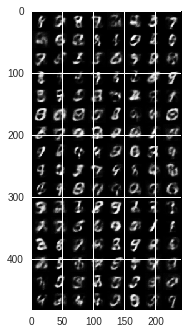

In [14]:
sample_01=plt.imread('samples/sampled-1.png')
plt.imshow(sample_01)

### Reconstructed Image


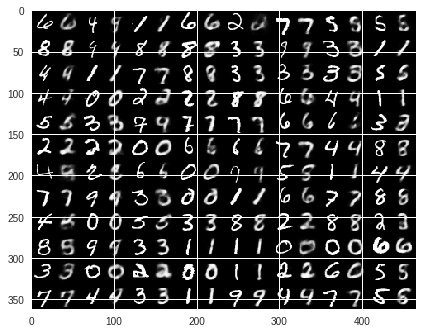

In [19]:
reconstruct_01=plt.imread('samples/reconst-1.png')
plt.imshow(reconstruct_01)

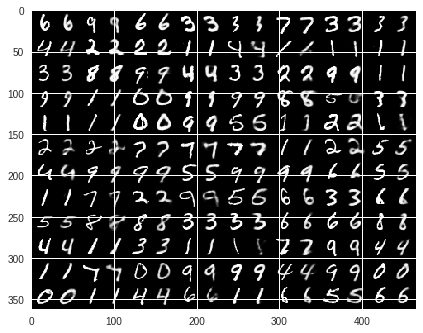

In [20]:
reconstruct_09=plt.imread('samples/reconst-9.png')
plt.imshow(reconstruct_09)